In [19]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.backend import clear_session

In [4]:
df = pd.read_csv(
    'preprocessed_CAC40.csv',
    parse_dates=['Date']
).drop('Unnamed: 0', axis=1)

COMPANY = "Accor"
START_DATE = dt.datetime(2015,1,1)
END_DATE = dt.datetime(2020,1,1)

START_DATE_TEST = END_DATE

data = df.copy()
data = data.loc[data.Name == 'Accor',:]
data = data.loc[(data['Date'] > START_DATE) & (data['Date'] < END_DATE), :]
data = data.rename(columns={'Closing_Price' : 'Close'})

data.head()

,Name,Date,Open,Close,Daily_High,Daily_Low,Volume
67,Accor,2019-12-30,42.10,42.10,42.10,42.10,NaN
68,Accor,2019-12-27,41.92,42.20,42.20,41.92,135
69,Accor,2019-12-23,41.08,42.09,42.09,41.08,10
70,Accor,2019-12-20,41.26,41.26,41.26,41.26,NaN
71,Accor,2019-12-19,41.31,41.31,41.31,41.31,NaN


In [5]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

scaled_data

array([[0.6435347 ],
       [0.64852721],
       [0.64303545],
       ...,
       [0.27608587],
       [0.31203195],
       [0.31752371]])

In [6]:
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x,0])
    y_train.append(scaled_data[x,0])

In [13]:
x_train,y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

#### LSTM Model

In [20]:
clear_session()
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.summary()
model.compile(
    optimizer = 'adam',
    loss='mean_squared_error'
)

checkpointer = ModelCheckpoint(
    filepath='weights_best.hdf5',
    verbose=2,
    save_best_only = True
)

history =  model.fit(
    x_train,
    y_train,
    epochs=25,
    batch_size=32,
    callbacks=[checkpointer]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 dense (Dense)               (None, 60, 1)             5

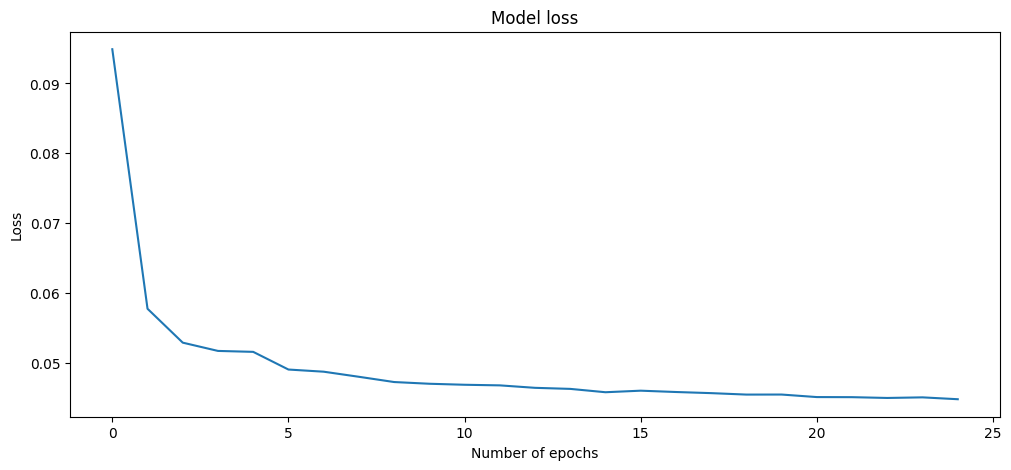

In [27]:
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.show()

#### Testing

In [34]:
#load test data
test_data = df.copy()
test_data = test_data.loc[test_data.Name == 'Accor']
test_data = test_data.loc[(test_data['Date'] > START_DATE_TEST) & (test_data['Date'] < dt.datetime.now() ), :]
test_data.rename(columns={'Closing_Price' : 'Close'},inplace=True)

test_data.head()

,Name,Date,Open,Close,Daily_High,Daily_Low,Volume
0,Accor,2020-04-03,22.99,23.40,23.40,22.99,67
1,Accor,2020-04-02,23.91,22.99,23.91,22.99,250
2,Accor,2020-04-01,24.10,23.83,24.10,23.83,37
3,Accor,2020-03-31,25.04,25.00,25.24,24.99,336
4,Accor,2020-03-30,26.50,25.02,26.50,24.99,415


In [48]:
# Extract the actual closing prices from the test data
actual_prices = test_data['Close'].values

# Concatenate the training and test data along the 'Close' column
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

# Reshape the model inputs to a 2D array with a single column
model_inputs = model_inputs.reshape(-1, 1)

# Apply the same scaling used for training data to the model inputs
model_inputs = scaler.transform(model_inputs)

In [64]:
# Initialize an empty list for test data input
x_test = []

# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_days, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])

# Convert the x_test list to a numpy array
x_test = np.array(x_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)

predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1,1))

predicted_prices

3/3 [==============================] - 0s 28ms/step


array([[37.382893],
       [39.89871 ],
       [40.703735],
       ...,
       [40.267483],
       [40.288742],
       [40.313797]], dtype=float32)